# Chapter 2 End to End ML Project

### California Housing Price Prediction

Business Objective - Predict the median prices of house beased on data for given districts. This is Supervised Multiple Regression task with Batch Learning for predicting univariate prediction (single value per district).


In [1]:
#Downloading the dataset

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path= HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

#Uncomment to download training dataset    
#fetch_housing_data()

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sns

In [3]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    

In [4]:
#Load the dataset
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
print(housing.shape)

housing.info()

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Total districts are 20640 but only 20433 total_bedrooms are present in data.

Let's look at unique categories in ocean proximity

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's look at other fields

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


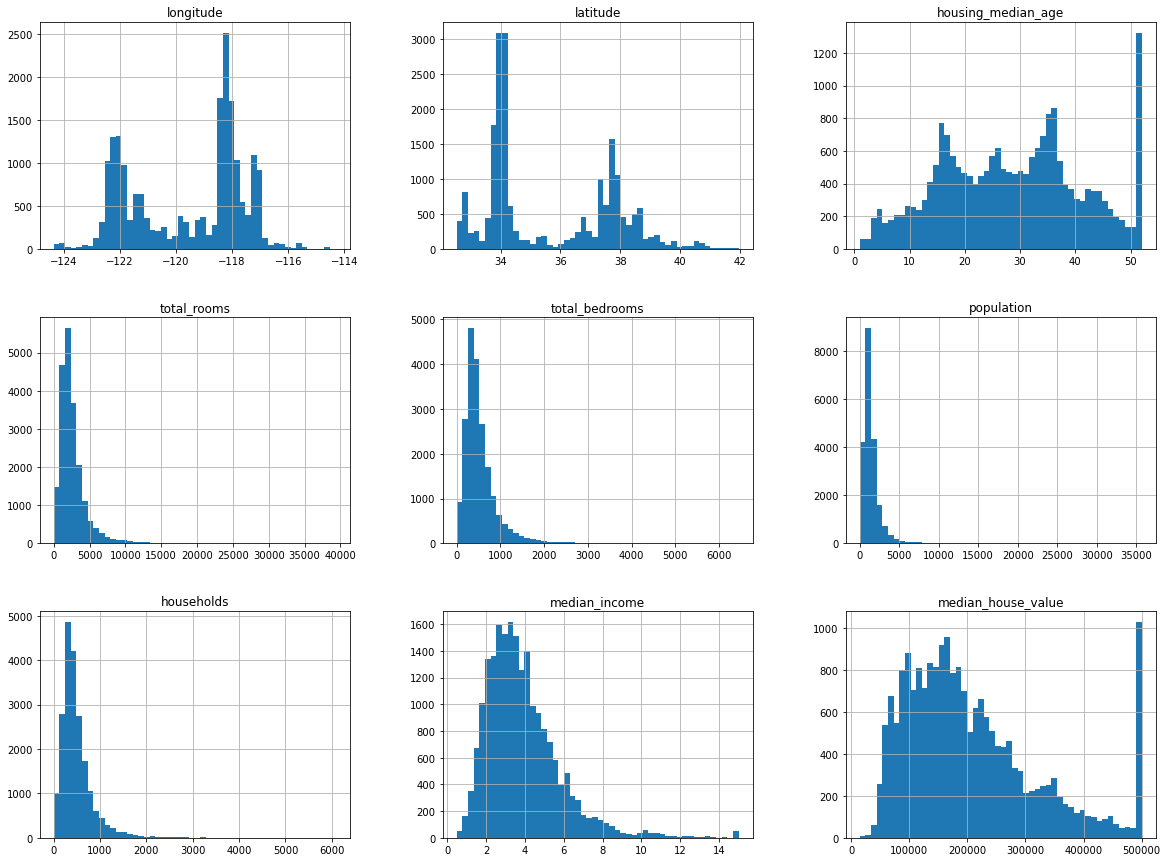

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

- Median income attribute has been scaled and capped to 15 (actually 15.0001) for higher median incomes and at 0.5 (actually 0.4999) for lower median incomes which represents roughly 10,000 dollars per unit.
- Housing median age and median house value were also capped. This may cause problems since ML algorithm may learn that prices never go beyond that limit. (Solution: Verify with clients, if they don't want cap, either collect fresh data for capped districts or remove capped districts for generalizing the predictions)
- Many histograms are tail heavy (right skewed - extend farther to the right of the median than to the left)

### Splitting data into Train and Test set

#### Random Sampling Methods
- If dataset is large enough (especially relative to number of attributes), this way of generating sets is fine. For smaller datasets, this may run the risk of introducing sampling bias.
- <b>Stratified Sampling: </b>Example if a company decides to call 1000 people for taking review, it won't pick 1000 people randomly. They will try to ensure that these 1000 people are representative of the whole population. Ex US population is comprised of 51.3% women and 48.7% men. So Comapny will try to maintain ratio in the sample as 513 women and 487 men. So pure random sampling here by 12% chance may cause skewed test set with either less than 49% female and more than 54% female, either way the survey would be significantly biased.


In [9]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size : ]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16512, 10) , test set: (4128, 10)


- We can populate training and test set by selecting index by random permutations but if we refresh importing dataset, we'll end up using some part of test dataset into training as well. 
- So one solution to this can be keep a fix np random state before calling np.random
But if the dataset was updated, this will also fail with the same problem.
- We can also hash each of the instance's identifier and put that instance in the test set if hash is lower or equal to 20% of maximum has value. This ensures test will remain consistent accross multiple runs even if we refresh dataset.
- The new test set will contain 20% of the new instances but it will not contain any instance that was previously in the training set.

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
#since housing dataset does not have identifier column, using row as index
housing_with_id = housing.reset_index() #adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16512, 11) , test set: (4128, 11)


For using row as unique index, we need to make sure that new data gets appended at the end of the dataset and no row ever gets deleted.


Maybe instead of row we can also try most stable feature to build unqiue identifier
For example, a district's latiture and longitude are guranteed to be stable for few million years

In [13]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16322, 12) , test set: (4318, 12)


Also sklearn provides train_test_split similar to split_train_test with some additional features like id and random state

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16512, 10) , test set: (4128, 10)


Suppose expert told us that median income is very important feature to predict median housing prices, then we may want to ensure that test set is representative of the various categories of incomes in the whole dataset.

Since median income is continuous numerical feature, we'll create income category attribute.
To do this let's look at the median income histogram more closely.

- Most median income values are clustered around 1.5 to 6 (i.e \\$15,000 to \\$60,000) but some median incomes go far beyond 6.
It is important to have sufficient instance in our dataset for each stratum or else the estimate of the stratum's importance may be biased. This means we should not have too many strata and each startum should be large enough.

Let's create income category attribute with 5 categories labelled from 1 to 5. Category 1 ranges from 0 to 1.5 (i.e. less than \\$15,000), category 2 from 1.5 to 3 and so on.

<AxesSubplot:>

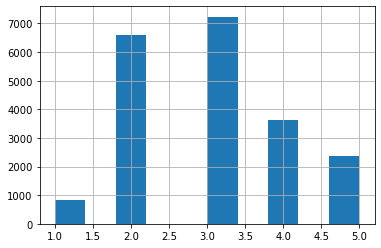

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

housing["income_cat"].hist()

#### Stratified Sampling
Now we are ready to do stratified sampling based on the income category. 

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [21]:
#Let's check if this worked
print("Split after stratified sampling: ")
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

Split after stratified sampling: 


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [22]:
#Splitting with random sampling for comapring income category proportions 
train_set , test_set = train_test_split(housing, test_size=0.2, random_state=42)

#Let's check if this worked
print("Split after random sampling: ")
test_set["income_cat"].value_counts()/len(test_set)

Split after random sampling: 


3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

Let's compare income category proportions of overall dataset with in the test set generated with stratified sampling and random sampling

In [36]:
print("Comapring income category split while generating test dataset using Stratified Sampling vs Random Sampling")
pd.DataFrame([
housing["income_cat"].value_counts() / len(housing),
strat_test_set["income_cat"].value_counts()/len(strat_test_set),
test_set["income_cat"].value_counts()/len(test_set),
((housing["income_cat"].value_counts() / len(housing)  - test_set["income_cat"].value_counts()/len(test_set)) *100/ (housing["income_cat"].value_counts() / len(housing)) ),
((housing["income_cat"].value_counts() / len(housing)  - strat_test_set["income_cat"].value_counts()/len(strat_test_set)) *100/ (housing["income_cat"].value_counts() / len(housing)) )

], index=["Overall dataset", "Stratified Sampling", "Random Sampling", "% Error Random", "% Error Stratfied"])

Comapring income category split while generating test dataset using Stratified Sampling vs Random Sampling


,3,2,4,5,1
Overall dataset,0.350581,0.318847,0.176308,0.114438,0.039826
Stratified Sampling,0.350533,0.318798,0.176357,0.114583,0.039729
Random Sampling,0.358527,0.324370,0.167393,0.109496,0.040213
% Error Random,-2.266446,-1.732260,5.056334,4.318374,-0.973236
% Error Stratfied,0.013820,0.015195,-0.027480,-0.127011,0.243309


From above example we can see that test set generated using stratified sampling has income category proportions almost identical to those in the full dataset whereas in test generated by random sampling is quite skewed. 

In [37]:
#Removing income_cat feature since it's work is done
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

### Exploring the data

In [39]:
#creating a copy of training set to play with the data
housing = strat_train_set.copy()

Text(0.5, 1.0, 'Geographical scatterplot of the data')

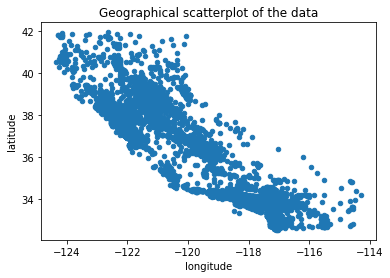

In [43]:
#visaulizing geographical data using scatterplot
housing.plot(kind = "scatter", x = "longitude", y="latitude")
plt.title("Geographical scatterplot of the data")

This looks like california but hard to see any perticular pattern. Setting alpha = 0.1 to visualize higher density of data points

Text(0.5, 1.0, 'Better Visualization highlighting high-density areas')

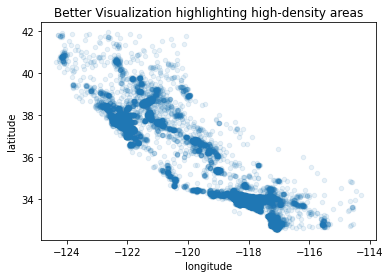

In [45]:
housing.plot(kind="scatter", x="longitude", y = "latitude", alpha=0.1)
plt.title("Better Visualization highlighting high-density areas")

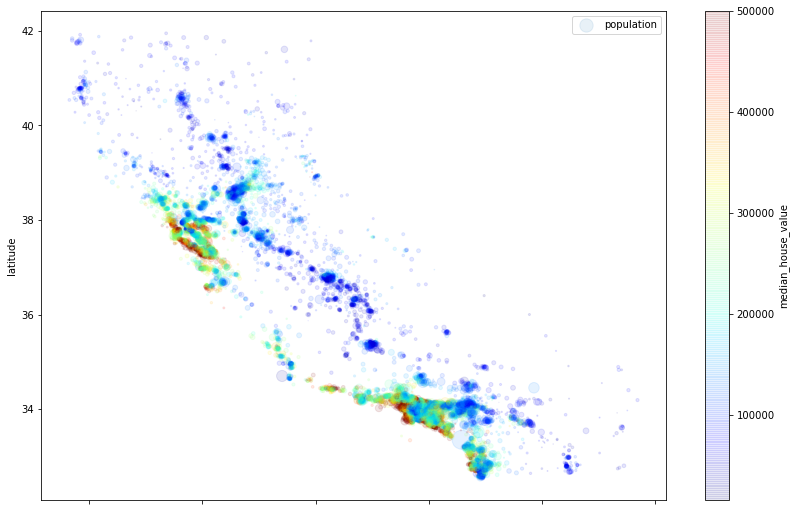

In [49]:
#Let's map housing prices to above visualization
#color map jet ranges from blue (low values) to red (high values)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.1,
            s = housing["population"]/100, label="population", figsize=(14, 9),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

Above graph shows that housing prices are very much related to the location (e.g. close to the ocean) and population density. It will probably be useful for clustering algorithm to detect main clsuters and add new features that measure proximity to the cluster centers. Ocean proximity attribute may be useful as well but still may not be simple rule since housing prices in coastal districts are not too high.